# U-Net

## Imports

In [1]:
import os
import sys
from datetime import datetime
sys.path.append('../../dataset')
from datasets import TrainDataset, TestDataset, ValDataset

import transforms as tran
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Load Data

In [2]:
transforms_augment = tran.Compose([
    tran.ToTensor(mask_as_integer=False),
    tran.Resize((256, 256)),
    tran.RandomHorizontalFlip(),
    tran.RandomVerticalFlip(),
])

transforms_val = tran.Compose([
    tran.ToTensor(mask_as_integer=False),
    tran.Resize((256, 256)),
])
train = TrainDataset('../../data/', transform=transforms_augment, with_background=True, as_id_mask=False)
val = ValDataset('../../data/', transform=transforms_val, with_background=True, as_id_mask=False)

print("Train set size before augmentation:", len(train))
print("Validation set size before augmentation:", len(val))

batch_size = 6
train_loader = DataLoader(train, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val, batch_size=batch_size, shuffle=True)

Train set size before augmentation: 1226
Validation set size before augmentation: 244


## U-Net Code

In [3]:
class UNet(nn.Module):
    def __init__(self, out_channels, encoder_name='resnet18', pretrained=True):
        super(UNet, self).__init__()
        if encoder_name == 'resnet18':
            self.encoder = models.resnet18(pretrained=pretrained)
        elif encoder_name == 'resnet34':
            self.encoder = models.resnet34(pretrained=pretrained)
        
        self.upconv1 = self.conv_transpose_block(512, 256)
        self.upconv2 = self.conv_transpose_block(256, 128)
        self.upconv3 = self.conv_transpose_block(128, 64)
        self.upconv4 = self.conv_transpose_block(64, 32)

        self.out_conv = nn.Conv2d(32, out_channels, kernel_size=1)

    def conv_transpose_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU()
        )

    def forward(self, x):
        # Pass input through the ResNet encoder
        x1 = self.encoder.relu(self.encoder.bn1(self.encoder.conv1(x)))
        x2 = self.encoder.layer1(x1)
        x3 = self.encoder.layer2(x2)
        x4 = self.encoder.layer3(x3)
        x5 = self.encoder.layer4(x4)

        x = self.upconv1(x5)
        x = self.upconv2(x)
        x = self.upconv3(x)
        x = self.upconv4(x)

        x = self.out_conv(x)
        return x

## Helper Methods used in Training Loop

In [4]:
def create_folder():
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    run_folder = f'checkpoints/{timestamp}'
    os.makedirs(run_folder)
    return run_folder

def log_specs(n_epochs, lr, model_name, encoder_name, 
              pretrained, optimizer_name, criterion_name,
              run_folder):
    
    config_details = f"""
    Epochs: {n_epochs}
    Learning Rate: {lr}
    Model: {model_name}
    Encoder: {encoder_name}
    Pretrained: {pretrained}
    Optimizer: {optimizer_name}
    Criterion: {criterion_name}
    """

    with open(f'{run_folder}/00_config.txt', 'w') as file:
        file.write(config_details)

def iou_score(output, target):
    ious = []
    for class_idx in range(4):  # Assuming 4 classes
        output_class = (output == class_idx)
        target_class = (target == class_idx)
        intersection = (output_class & target_class).float().sum()
        union = (output_class | target_class).float().sum()
        ious.append((intersection + 1e-6) / (union + 1e-6))  # Avoid division by zero
    return ious


def log_metrics(run_folder, train_ious, val_ious, train_losses, val_losses):
    ## IoUs
    train_ious_df = pd.DataFrame({'train_iou': train_ious})
    train_ious_csv_path = f'{run_folder}/00_train_ious.csv'
    train_ious_df.to_csv(train_ious_csv_path, index=False)

    val_ious_df = pd.DataFrame({'val_iou': val_ious})
    val_ious_csv_path = f'{run_folder}/00_val_ious.csv'
    val_ious_df.to_csv(val_ious_csv_path, index=False)

    ## Losses
    train_losses_df = pd.DataFrame({'train_loss': train_losses})
    train_losses_csv_path = f'{run_folder}/00_train_losses.csv'
    train_losses_df.to_csv(train_losses_csv_path, index=False)

    val_losses_df = pd.DataFrame({'val_loss': val_losses})
    val_losses_csv_path = f'{run_folder}/00_val_losses.csv'
    val_losses_df.to_csv(val_losses_csv_path, index=False)

    # Saving max_train_max_val
    max_values_df = pd.DataFrame({
        'max_train_iou': [max(train_ious)],
        'max_val_iou': [max(val_ious)]
    })
    max_values_csv_path = f'{run_folder}/00_max_train_max_val.csv'
    max_values_df.to_csv(max_values_csv_path, index=False)

class FocalLoss(nn.Module):
    def __init__(self, alpha, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, input, target):
        ce_loss = nn.functional.cross_entropy(input, target, reduction='none')  # Shape: (batch_size, H, W)
        pt = torch.exp(-ce_loss)
        alpha_t = self.alpha[target.view(-1)].view(target.size())  # Reshape alpha to match target shape
        loss = alpha_t * (1 - pt) ** self.gamma * ce_loss
        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        else:
            return loss

## Config Training

In [5]:
learning_rates = [0.0001, 0.0005, 0.001, 0.0025, 0.005, 0.01]
encoder_names = ["resnet18", "resnet34"]
losses = ["CEL", "FC"]
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
n_epochs = 2
print(device)

cuda


## Training Loop

In [ ]:

for lr in learning_rates:
    for encoder_name in encoder_names:
        for loss in losses:
        ## Define setup
            lr = lr
            pretrained = True #False
            model = UNet(out_channels=4,encoder_name=encoder_name,
                            pretrained=pretrained).to(device)
            optimizer = optim.Adam(model.parameters(), lr=lr)
            if loss == "CEL":
                criterion = nn.CrossEntropyLoss()
                criterion_name = "CrossEntropyLoss"
            elif loss == "FC":
                alpha = torch.tensor([0.5, 0.5, 0.5, 0.1]).to(device) # More weight to blood_vessel, glomerulus, and unsure
                criterion = FocalLoss(gamma=2, alpha=alpha)
                criterion_name = "FocalLoss"

            optimizer_name = optimizer.__class__.__name__
            model_name = model.__class__.__name__

            run_folder = create_folder()

            log_specs(n_epochs=n_epochs, lr=lr, model_name=model_name,
                    encoder_name=encoder_name, pretrained=pretrained, 
                    optimizer_name=optimizer_name, criterion_name=criterion_name,
                    run_folder=run_folder)


            train_losses = []
            train_ious = []
            val_losses = []
            val_ious = []

            for epoch in range(n_epochs):
                model.train()
                train_loss = 0
                mean_iou = 0

                for images, masks in train_loader:
                    images = images.to(device)
                    masks = torch.argmax(masks, dim=1).to(device)

                    optimizer.zero_grad()
                    outputs = model(images)
                    loss = criterion(outputs, masks)

                    preds = torch.argmax(outputs, dim=1)
                    ious = iou_score(preds, masks)
                    mean_iou += torch.mean(torch.tensor(ious)).item()

                    loss.backward()
                    optimizer.step()
                    train_loss += loss.item()
                
                train_losses.append(train_loss / len(train_loader))
                train_ious.append(mean_iou / len(train_loader))


                model.eval()
                val_loss = 0
                mean_val_iou = 0

                with torch.no_grad():
                    for images, masks in val_loader:
                        images = images.to(device)
                        masks = torch.argmax(masks, dim=1).to(device)

                        outputs = model(images)
                        loss = criterion(outputs, masks)
                        preds = torch.argmax(outputs, dim=1)

                        ious = iou_score(preds, masks)
                        mean_val_iou += torch.mean(torch.tensor(ious)).item()
                        val_loss += loss.item()

                val_losses.append(val_loss / len(val_loader))
                val_ious.append(mean_val_iou / len(val_loader))

                save_path = f'{run_folder}/model_epoch_{epoch}.pth'

                torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'loss': loss,
                }, save_path)

            log_metrics(run_folder=run_folder, train_ious=train_ious, val_ious=val_ious, train_losses=train_losses, val_losses=val_losses)

## Check Training logs

In [ ]:
run = "20230818_202449"
# Read and print max_train_max_val.csv
max_values_path = f'checkpoints/{run}/00_max_train_max_val.csv'
max_values_df = pd.read_csv(max_values_path)
print("\nMax Train and Validation IOUs:")
print(max_values_df)

# Read and print train_ious.csv
train_ious_path = f'checkpoints/{run}/00_train_ious.csv'
train_ious_df = pd.read_csv(train_ious_path)
print("Train IOUs:")
print(train_ious_df)

# Read and print val_ious.csv
val_ious_path = f'checkpoints/{run}/00_val_ious.csv'
val_ious_df = pd.read_csv(val_ious_path)
print("\nValidation IOUs:")
print(val_ious_df)


Max Train and Validation IOUs:
   max_train_iou  max_val_iou
0       0.354338     0.407417
Train IOUs:
   train_iou
0   0.311993
1   0.354338

Validation IOUs:
    val_iou
0  0.357477
1  0.407417


## Plot Training logs

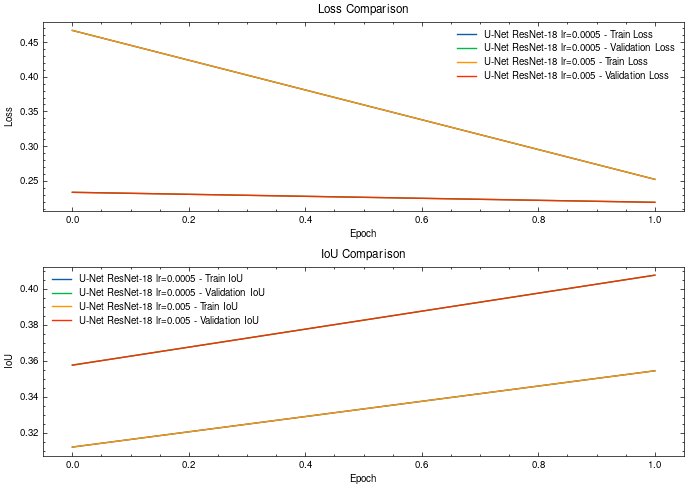

In [ ]:
import scienceplots as _

plt.style.use({"science", "nature"})
def read_data(run, filename):
    path = f'checkpoints/{run}/{filename}.csv'
    df = pd.read_csv(path)
    return df.iloc[:, 0]

# INSERT RUN NUMBER HERE
runs = {
    "U-Net ResNet-18 lr=0.0005": "20230818_202449",
    "U-Net ResNet-18 lr=0.005": "20230818_202449"
}

fig, axes = plt.subplots(2, 1, figsize=(7, 5))

for label, run in runs.items():
    train_loss_df = read_data(run, '00_train_losses')
    val_loss_df = read_data(run, '00_val_losses')
    train_iou_df = read_data(run, '00_train_ious')
    val_iou_df = read_data(run, '00_val_ious')

    axes[0].plot(train_loss_df, label=f"{label} - Train Loss")
    axes[0].plot(val_loss_df, label=f"{label} - Validation Loss")
    
    axes[1].plot(train_iou_df, label=f"{label} - Train IoU")
    axes[1].plot(val_iou_df, label=f"{label} - Validation IoU")

axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Loss Comparison')
axes[0].legend()

axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('IoU')
axes[1].set_title('IoU Comparison')
axes[1].legend()

plt.tight_layout()
plt.savefig('unet_loss_comparison.svg', format='svg')
plt.show()
